In [1]:
from time import sleep
from collections import namedtuple, deque
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import math
import random

from pettingzoo.classic import connect_four_v3

import pygame

In [2]:
# if GPU is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
#env = connect_four_v3.env(render_mode="human")
env = connect_four_v3.env()
env.reset()

In [4]:
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 0.001
TAU = 0.005
LR = 1e-4

In [5]:
# Get number of actions from gym action space
n_actions = 7

# Get the number of state observations
observation, reward, termination, truncation, info = env.last()

observation_shape = np.array(observation["observation"]).reshape(1,-1)
n_observations = 84



In [6]:
class ActorNetwork(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(ActorNetwork, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

In [7]:
class CriticNetwork(nn.Module):
    def __init__(self, state_size, action_size):
        super(CriticNetwork, self).__init__()
        self.linear1 = nn.Linear(state_size, 128)
        self.linear2 = nn.Linear(128, 128)
        self.linear3 = nn.Linear(128, 1)

    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        return self.linear3(x)

In [8]:
class SAC:
    def __init__(self,lr,gamma, eps_start,eps_end,eps_dec, n_actions,action_space,policy_net,policy_optimizer,target_net,target_optimizer):
        
        self.lr = lr
        self.gamma = gamma
        self.epsilon = eps_start
        self.eps_end = eps_end
        self.eps_dec = eps_dec
        
        self.n_actions = n_actions
        self.action_space = action_space

        self.policy_net = policy_net
        self.policy_optimizer = policy_optimizer
        self.target_net = target_net
        self.target_optimizer = target_optimizer

        self.memory = []

        self.criterion = nn.MSELoss()
        self.probs = []
        self.loss = 0




    def choose_action(self, agent, state):
        if np.random.random() < self.epsilon:
            action = env.action_space(agent).sample(state["action_mask"])
        else:
            action_mask = torch.tensor(state["action_mask"])
            state_tensor = torch.FloatTensor(np.array(state["observation"]).reshape(1,-1))
            
            q_values = self.policy_net(state_tensor)
            max, min= torch.max(q_values), torch.min(q_values)
            q_values = (q_values-min)/ (max-min)
            valid_actions = action_mask *  q_values

            #self.probs = valid_actions

            action = np.argmax(valid_actions.detach().numpy())


            self.policy_net.train()
            self.decrement_epsilon()

        return action
    
    def update(self, state,new_state, reward):
        
        
        
        state_tensor = torch.FloatTensor(np.array(state["observation"]).reshape(1,-1))
        new_state_tensor = torch.FloatTensor(np.array(new_state["observation"]).reshape(1,-1))
        action_mask = torch.tensor(new_state["action_mask"])
        """
        new_q_values = self.policy_net(new_state_tensor)
        max, min= torch.max(new_q_values), torch.min(new_q_values)
        q_values = (q_values-min)/ (max-min)
        new_probs = action_mask *  q_values
        new_q_value = np.argmax(new_probs.detach().numpy())"""



        state_value = self.target_net(state_tensor)
        new_state_value = reward + (self.gamma* self.target_net(new_state_tensor))
        
        self.loss = self.criterion(state_value,new_state_value)

        self.loss.backward()


    def update_memory(self,state, reward, termination, truncation, info):
        self.memory.append((state, reward, termination, truncation, info))

    def clear_memory(self):
        self.memory = []


    def optimize(self):
        self.policy_optimizer.zero_grad()
        self.target_optimizer.zero_grad()
        
        self.policy_optimizer.step()
        self.target_optimizer.step()
    
    def decrement_epsilon(self):
        self.epsilon = self.epsilon - self.eps_dec \
            if self.epsilon > self.eps_end else self.eps_end
    


In [9]:
policy_net = ActorNetwork(n_observations, n_actions).to(device)
target_net = CriticNetwork(n_observations, n_actions).to(device)
#target_net.load_state_dict(policy_net.state_dict())

Actor_optimizer = optim.Adam(policy_net.parameters(), lr=LR, amsgrad=True)
Critic_optimizer = optim.Adam(target_net.parameters(), lr=LR, amsgrad=True)

sac_agent = SAC(lr=LR,gamma=GAMMA,eps_start=EPS_START,
                eps_end=EPS_END,eps_dec=EPS_DECAY,
                n_actions=n_actions,action_space=n_observations,
                policy_net=policy_net,policy_optimizer=Actor_optimizer,
                target_net=target_net,target_optimizer=Critic_optimizer)


In [10]:
# Inicializa pygame
#pygame.init()

# Crea la ventana
#screen = pygame.display.set_mode ( (400,400),pygame.RESIZABLE )
#pygame.VIDEORESIZE

agent_score = []

num_episodes = 2000
total_reward_player_0 = 0
total_reward_player_1 = 0
last_action_player_1 = 0
previous_state = observation

for episode in range(num_episodes):


    state = env.reset()
    #env.render()
    


    for agent in env.agent_iter():
        #print(agent)
        state, reward, termination, truncation, info = env.last()
        sac_agent.update_memory(state, reward, termination, truncation, info)


        if termination or truncation:
                #print(env.rewards)
                total_reward_player_0 = total_reward_player_0 + env.rewards["player_0"]
                total_reward_player_1 = total_reward_player_1 + env.rewards["player_1"]
                sac_agent.optimize()
                agent_score.append(total_reward_player_1)
                sac_agent.clear_memory
                #sac_agent.learn(previous_state,last_action_player_1,total_reward_player_1,state)

                break
        
        if(agent == "player_0"):
            #print("Player 1")

            mask = state["action_mask"]
            action = env.action_space(agent).sample(mask)  # this is where you would insert your policy
            #print(action)
            env.step(action)
        else:
            #print("Player 2")
            
            mask = state["action_mask"]
            #action = env.action_space(agent).sample(mask)  # this is where you would insert your policy
            action= sac_agent.choose_action(agent,state)

            #state_tensor = torch.FloatTensor(np.array(state["observation"]).reshape(1,-1))

            #action = policy_net.act(state_tensor)
            #print(action)
            #print(action)
            #action = int(input("Elige la columna: \n")) - 1 
            env.step(action) 

            new_state, new_reward, new_termination, new_truncation, new_info = env.last()
            sac_agent.update(state,new_state,new_reward)
            


            last_action_player_1 = action 
        previous_state = state["observation"]
    env.close()

print("Total score player 1: " + str(total_reward_player_0))
print("Total score player 2: " + str(total_reward_player_1))


UnboundLocalError: cannot access local variable 'q_values' where it is not associated with a value

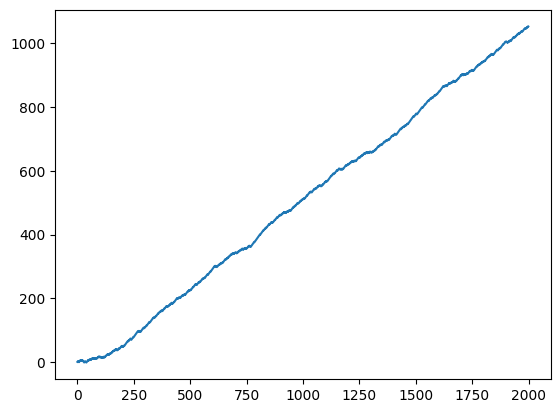

In [ ]:
plt.plot(agent_score)
plt.show()

In [ ]:
"""
Referencias:

https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html

"""

'\nReferencias:\n\nhttps://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html\n\n'